In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import networkx as nx


from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Exploración inicial y preprocesamiento de datos

In [2]:
dataset = pd.read_csv("groceries.csv", sep=";", header= None)

dataset.head()


,0
0,"citrus fruit,semi-finished bread,margarine,rea..."
1,"tropical fruit,yogurt,coffee"
2,whole milk
3,"pip fruit,yogurt,cream cheese ,meat spreads"
4,"other vegetables,whole milk,condensed milk,lon..."


In [3]:
transactions = [transaction.split(',') for transaction in dataset[0]]
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Eliminamos filas con solo 1 elemento
df = df.drop(df[df.sum(axis=1) == 1].index)
df


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
5,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9829,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
9830,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,True,False,False
9832,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
9833,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [4]:
purchased = []
for i in df.columns:
    purchased.append(list(df[i].value_counts())[1])

count_df = pd.DataFrame([purchased], columns=df.copy().columns)
count_df.index = ['times_purchased']

In [5]:
count_df.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
times_purchased,76,319,34,31,5,1,2,171,24,490,...,78,64,357,679,7,407,168,2392,1332,62


In [6]:
sorted_df = pd.DataFrame(count_df.sort_values(by=['times_purchased'],axis=1,ascending=False).transpose())
sorted_df = sorted_df.reset_index()
sorted_df = sorted_df.rename(columns={'index': 'item'})
sorted_df['percentage'] = round(sorted_df["times_purchased"]/df.shape[0]*100, 2)
sorted_df

,item,times_purchased,percentage
0,whole milk,2392,31.16
1,other vegetables,1841,23.98
2,rolls/buns,1700,22.15
3,soda,1559,20.31
4,yogurt,1332,17.35
...,...,...,...
164,kitchen utensil,3,0.04
165,preservation products,2,0.03
166,bags,2,0.03
167,sound storage medium,1,0.01


Hemos visto algunos elementos poco comunes que pueden unificarse en una misma categoría. Esto se va a hacer para que puedan tenerse en cuenta al aplicar el algoritmo apriori sin necesidad de bajar tanto el suport mínimo a tener en cuenta y, por tanto, puedan encontrar alguna regla más. 

In [7]:
df_table = sorted_df.copy()
df_table["most_common"] = "most_common" 

fig = px.treemap(df_table.head(20), path=['most_common', "item"], values='percentage',
                  color=df_table["percentage"].head(20), hover_data=['item'],
                  color_continuous_scale='Purples',
                  )
fig.show()

In [8]:
df_table = df_table.drop(columns=["most_common"])


In [9]:
df_table[df_table["percentage"] < 1]

,item,times_purchased,percentage
98,Instant food products,76,0.99
99,rice,75,0.98
100,liquor (appetizer),73,0.95
101,instant coffee,69,0.90
102,popcorn,69,0.90
...,...,...,...
164,kitchen utensil,3,0.04
165,preservation products,2,0.03
166,bags,2,0.03
167,sound storage medium,1,0.01


In [10]:
df["beer"] = df["canned beer"] | df ["bottled beer"]
df["whine"] = df["white wine"] | df["red/blush wine"] | df["sparkling wine"] | df["prosecco"]
df["pet items"] = df["cat food"] | df ["dog food"] | df["pet care"]
df["sauce"] = df["sauces"] | df ["ketchup"] | df["mayonnaise"] | df ["mustard"]
df["alcoholic beverages"] = df["liqueur"] | df["liquor"] | df["liquor (appetizer)"] | df["whisky"] | df["brandy"]
df["cheese"] = df["curd cheese"] | df["hard cheese"] | df["soft cheese"] | df["sliced cheese"] | df["spread cheese"] | df["processed cheese"] | df["specialty cheese"]
df["coffee"] = df["coffee"] | df["instant coffee"]
df["vegetables"] = df["root vegetables"] | df ["other vegetables"] | df["specialty vegetables"]
df["fruits"] = df["canned fruit"] | df["citrus fruit"] | df["frozen fruits"] | df["pip fruit"] | df["tropical fruit"]

columnas_a_eliminar = ["canned beer", "bottled beer", "white wine", "red/blush wine", "sparkling wine", "prosecco", "cat food", "dog food", "pet care", "sauces", "ketchup", "mayonnaise", "mustard", "liqueur", "liquor", "liquor (appetizer)", "whisky", "brandy", "curd cheese", "hard cheese", "soft cheese", "sliced cheese", "spread cheese", "processed cheese", "specialty cheese", "coffee", "instant coffee"]
columns_to_drop = ["root vegetables", "other vegetables", "specialty vegetables", "canned fruit", "citrus fruit", "frozen fruits", "pip fruit", "tropical fruit"]

# Reasignar las columnas originales
df.drop(columns=columns_to_drop, inplace=True)
df = df.drop(columns=columnas_a_eliminar)

In [17]:
purchased = []
for i in df.columns:
    purchased.append(list(df[i].value_counts())[1])

count_df = pd.DataFrame([purchased], columns=df.copy().columns)
count_df.index = ['times_purchased']


In [20]:
sorted_df = pd.DataFrame(count_df.sort_values(by=['times_purchased'],axis=1,ascending=False).transpose())
sorted_df = sorted_df.reset_index()
sorted_df = sorted_df.rename(columns={'index': 'item'})
sorted_df['percentage'] = round(sorted_df["times_purchased"]/df.shape[0]*100, 2)
sorted_df
sorted_df[sorted_df["percentage"] < 1].shape

(58, 3)

# Generación de reglas

Primero vamos a aplicar el algoritmo con un support mínimo de 0.01 y un lift mínimo de 2.5. A continuación, vamos a filtrar todos los resultados en orden 
descendente por leverage para juntar las relaciones que sean simétricas y eliminarlas.
Con esto vamos a buscar reglas que relacionen productos con una fiabilidad bastante alta.
 

In [11]:

frequent_itemsets= apriori(df, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=2.5)
redundancy = rules.sort_values(by=['leverage','confidence'],axis=0, ascending=False)
unique_rules = redundancy.iloc[::2].reset_index()
unique_rules = unique_rules.drop(['index'], axis=1)
unique_rules = unique_rules.head(10)
unique_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(yogurt, vegetables)","(fruits, whole milk)",0.072564,0.106305,0.020584,0.283662,2.668374,0.012870,1.247589,0.674160
1,"(yogurt, vegetables)",(whipped/sour cream),0.072564,0.088458,0.016936,0.233393,2.638477,0.010517,1.189061,0.669581
2,(alcoholic beverages),(beer),0.027749,0.149818,0.013679,0.492958,3.290386,0.009522,1.676749,0.715951
3,"(whipped/sour cream, fruits)","(vegetables, whole milk)",0.034523,0.129104,0.013158,0.381132,2.952139,0.008701,1.407241,0.684908
4,"(whipped/sour cream, whole milk)","(fruits, vegetables)",0.041298,0.116206,0.013158,0.318612,2.741778,0.008359,1.297049,0.662638
5,"(fruits, vegetables, whole milk)",(whipped/sour cream),0.055237,0.088458,0.013158,0.238208,2.692903,0.008272,1.196576,0.665409
6,(ham),(cheese),0.032830,0.119724,0.012116,0.369048,3.082491,0.008185,1.395155,0.698519
7,(curd),"(yogurt, whole milk)",0.067092,0.071782,0.012897,0.192233,2.678005,0.008081,1.149116,0.671650
8,"(whipped/sour cream, vegetables)","(fruits, whole milk)",0.048072,0.106305,0.013158,0.273713,2.574778,0.008048,1.230497,0.642503
9,(berries),(whipped/sour cream),0.041298,0.088458,0.011595,0.280757,3.173920,0.007942,1.267364,0.714437


Bajamos el support mínimo a 0.005


In [12]:
frequent_itemsets= apriori(df, min_support=0.005, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=2.5)
redundancy = rules.sort_values(by=['leverage','confidence'],axis=0, ascending=False)
unique_rules2 = redundancy.iloc[::2].reset_index()
unique_rules2 = unique_rules2.drop(['index'], axis=1)
unique_rules2 = unique_rules2.head(10)

Ahora vamos a calcular un lift menor a 1. Esto se va a hacer para buscar a ver si existen relaciones negativas, es decir, que la compra de un producto reduzca la posibilidad de de compra de otro. Esto puede ser útil para no poner ambos productos juntos ya que muy probablemente nadie los compre de manera conjunta.

In [13]:

frequent_itemsets= apriori(df, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=0)
redundancy = rules.sort_values(by=['leverage','confidence'],axis=0, ascending=True)
unique_rules3 = redundancy.iloc[::2].reset_index()
unique_rules3 = unique_rules3.drop(['index'], axis=1)
unique_rules3 = unique_rules3.head(10)

# Visualización de datos

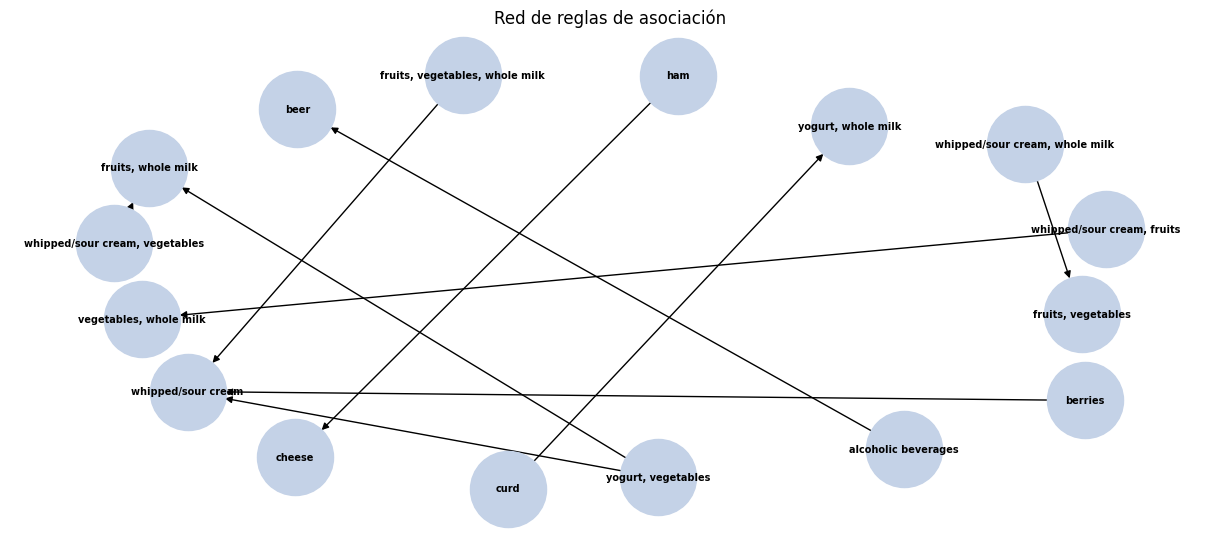

In [14]:
# Crear un grafo dirigido
G = nx.DiGraph()

# Agregar nodos y aristas al grafo
for idx, row in unique_rules.iterrows():
    antecedents = ', '.join(row['antecedents'])
    consequents = ', '.join(row['consequents'])
    G.add_edge(antecedents, consequents, support=row['support'], lift=row['lift'])

# Dibujar el grafo
plt.figure(figsize=(12, 5))
node_sizes = [len(node) * 100 for node in G.nodes()]

pos = nx.spring_layout(G, k=2.5, scale=50)  
nx.draw(G, pos, with_labels=True, node_size=3000 , node_color='#c4d2e7', font_size=7, font_weight='bold', font_color='black')

# Mostrar el grafo
plt.title('Red de reglas de asociación')
plt.show()

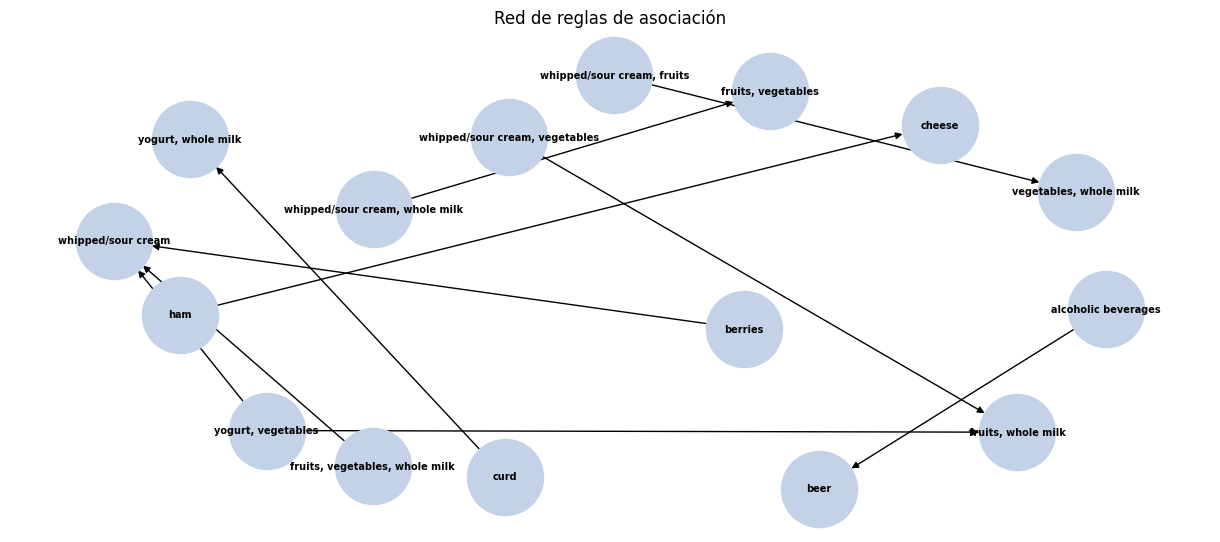

In [15]:
# Crear un grafo dirigido
G = nx.DiGraph()

# Agregar nodos y aristas al grafo
for idx, row in unique_rules2.iterrows():
    antecedents = ', '.join(row['antecedents'])
    consequents = ', '.join(row['consequents'])
    G.add_edge(antecedents, consequents, support=row['support'], lift=row['lift'])

# Dibujar el grafo
plt.figure(figsize=(12, 5))
pos = nx.spring_layout(G, k=2, scale=50)  
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='#c4d2e7', font_size=7, font_weight='bold', font_color='black')

# Mostrar el grafo
plt.title('Red de reglas de asociación')
plt.show()

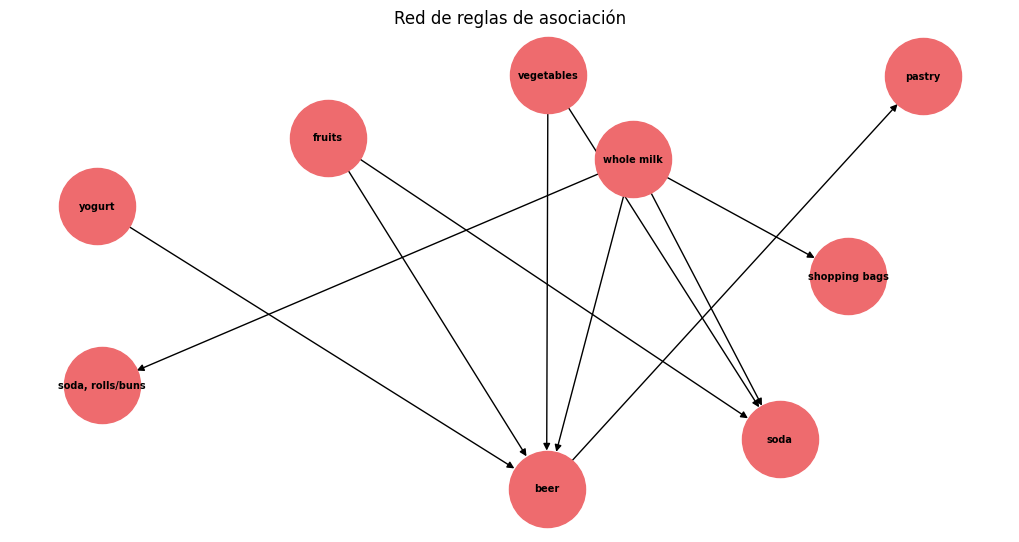

In [16]:
# Crear un grafo dirigido
G = nx.DiGraph()

# Agregar nodos y aristas al grafo
for idx, row in unique_rules3.iterrows():
    antecedents = ', '.join(row['antecedents'])
    consequents = ', '.join(row['consequents'])
    G.add_edge(antecedents, consequents, support=row['support'], lift=row['lift'])

# Dibujar el grafo
plt.figure(figsize=(10, 5))
pos = nx.spring_layout(G, k=2, scale=50)  

# Dibujar los nodos
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='#ee6b6e', font_size=7, font_weight='bold', font_color='black')

# Mostrar el grafo
plt.title('Red de reglas de asociación')
plt.show()